In [ ]:
import cv2
import numpy as np
import h5py
import argparse
from pathlib import Path
import roboticstoolbox as rtb
import json
import open3d as o3d
from multiprocessing.shared_memory import SharedMemory
import numpy as np
from scipy.spatial.transform import Rotation as R
import pyquaternion as pyq  
from scipy.optimize import minimize
import json
import os


def wait_for_data(width, height, control_data:np.ndarray, data_shm:SharedMemory):
    while True:
        try:
            if control_data[0] <= 0.5:
                buffer = np.ndarray((height, width, 3), dtype=np.uint8, buffer=data_shm.buf)
                image = np.array(buffer)
                return image
        except Exception as e:
            print(control_data)
            raise e

def send_by_shm(control_data:np.ndarray, cam_pose, fx, fy, width, height):
    cam_trans, cam_rot = cam_pose
    control_data[1:4] = cam_trans
    control_data[4:8] = cam_rot
    control_data[8] = fx
    control_data[9] = fy
    control_data[10] = width
    control_data[11] = height
    control_data[0] = 1.0
    
def get_rendered_images(cam_pose, height, width, fx, fy):
    control_shm = SharedMemory(name='control_psm_08d5dd701')
    data_shm = SharedMemory(name="data_psm_08d5dd701")
    control_data = np.ndarray((12,), dtype=np.float64, buffer=control_shm.buf)
    position = cam_pose[0]
    rotation = cam_pose[1]
    send_by_shm(control_data, cam_pose, fx, fy, width, height)
    image = wait_for_data(width, height, control_data, data_shm)
    return image

def get_to_marker_pose(image, camera_params, tag_size, detector, min_num=4):
    '''
    input a image in bgr format,
    get the pose: camera -> marker
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    results = detector.detect(gray, estimate_tag_pose=True, camera_params=camera_params, tag_size=tag_size)
    if len(results) < min_num:
        return None
    res = None
    for result in results:
        if result.tag_id == 22222:
            res = result
            break
    if res is None:
        return None
    pose = np.eye(4)
    pose[:3, :3] = res.pose_R
    pose[:3, 3] = res.pose_t[:, 0]
    pose = np.linalg.inv(pose)
    hope2now = np.eye(4)
    hope2now[1, 1] = -1
    hope2now[2, 2] = -1
    now2hope = np.linalg.inv(hope2now)
    tmp_trans = np.eye(4)
    tmp_trans[2, 2] = -1
    pose = now2hope @ pose 
    return pose

def create_camera_model(size=0.1):
    mesh_camera = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=[0, 0, 0])
    return mesh_camera

def show_pose(camera_pose, size=0.1):
    camera_pose = np.array(camera_pose)
    camera_pose[:3, :3] = camera_pose[:3, :3] / np.abs((np.linalg.det(camera_pose[:3, :3]))) ** (1/3)
    tmp_tans = np.eye(4)
    tmp_tans[2, 2] = -1
    camera_model = create_camera_model(size)
    camera_model.transform(camera_pose)
    return camera_model

def filter_and_compute_mean_std(matrices, outlier_percent=0.1):
    """
    Filter out a given percentage of outliers from the matrices and compute the mean and standard deviation.

    Parameters:
    matrices (numpy.ndarray): A numpy array of shape (n, m, m) representing n m x m matrices.
    outlier_percent (float): The percentage of outliers to remove (0 < outlier_percent < 0.5), default is 10%.

    Returns:
    mean_matrix (numpy.ndarray): The mean matrix after filtering out outliers.
    std_matrix (numpy.ndarray): The standard deviation matrix after filtering out outliers.
    """
    # Step 1: Compute the norm of each matrix
    norms = np.linalg.norm(matrices, axis=(1, 2))

    # Step 2: Sort the norms
    sorted_indices = np.argsort(norms)

    # Step 3: Compute the bounds for removing outliers
    n_matrices = len(matrices)
    lower_bound = int(n_matrices * outlier_percent)
    upper_bound = int(n_matrices * (1 - outlier_percent))

    # Step 4: Filter matrices
    filtered_indices = sorted_indices[lower_bound:upper_bound]
    filtered_matrices = matrices[filtered_indices]

    # Step 5: Compute the mean and standard deviation after removing outliers
    mean_matrix = np.mean(filtered_matrices, axis=0)
    std_matrix = np.std(filtered_matrices, axis=0)

    return mean_matrix, std_matrix

print("1")

1


In [58]:
log_folder = "/home/pjlab/.local/share/ov/pkg/isaac-sim-4.0.0/src/frankapy/logs/2024-09-22_17-52-45/log-000002-5588"
calibration_eyeonbase_results_dir = "/home/pjlab/Franka_Tool/catkin_ws_2/src/easy_handeye/results/eye_on_base/9-23--20-34.json"
gs_dir = "/home/pjlab/main/real2sim/gaussian-splatting/data/new/mix2/gs-output/1"
marker_2_base = np.load("/home/pjlab/.local/share/ov/pkg/isaac-sim-4.0.0/src/assets/marker_2_base.npy")
output_dir = "/home/pjlab/.local/share/ov/pkg/isaac-sim-4.0.0/src/frankapy/tests/test-render"

In [ ]:
from scipy.spatial.transform import Rotation as R


def render_in_marker(cam_2_marker, image_height, image_width, fx, fy):
    """
    return an image in RGB format
    """
    gs_2_marker = np.load(Path(gs_dir) / "gs_to_marker.npy")
    wrist_camera_pose = np.linalg.inv(gs_2_marker) @ rtb.ET.Rz(np.pi / 2).A() @ cam_2_marker 
    rotation_matrix = wrist_camera_pose[:3, :3] / np.abs((np.linalg.det(wrist_camera_pose[:3, :3]))) ** (1/3)
    translation = wrist_camera_pose[:3, 3]
    x, y, z, w = R.from_matrix(rotation_matrix).as_quat()
    wrist_camera_pose = [translation, [w, x, y, z]]

    image = get_rendered_images(
        wrist_camera_pose,
        image_height,
        image_width,
        fx, 
        fy
    )
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    return image 


fx, fy, width, height: 606.1884765625 605.8399047851562 640 480
cam_base:
[[ 0.41013727 -0.63005375  0.65940859 -0.12077388]
 [-0.87774559 -0.07632762  0.47300821 -0.47725408]
 [-0.24768951 -0.77279128 -0.58433171  0.63869659]
 [ 0.          0.          0.          1.        ]]


True

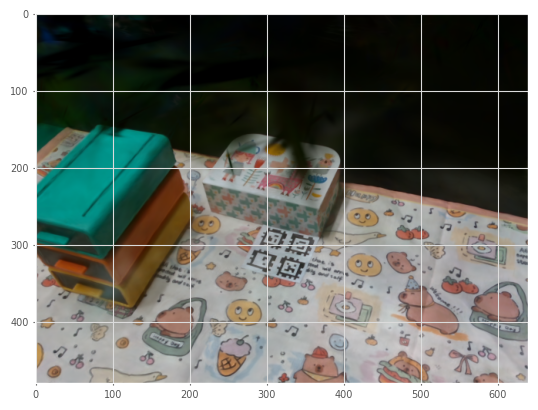

In [ ]:
from pupil_apriltags import Detector
import os

os.environ["DISPLAY"] = ":1"
# file path
log_folder = Path(log_folder)
hdf5_file = log_folder / "traj.hdf5"
with open(calibration_eyeonbase_results_dir, 'r') as f:
    calibration_results = json.load(f)

hdf5_file = h5py.File(hdf5_file, "r")
fx, fy = hdf5_file["intrinsic_color_0"]["fx"][()], hdf5_file["intrinsic_color_0"]["fy"][()]
cx, cy = hdf5_file["intrinsic_color_0"]["ppx"][()], hdf5_file["intrinsic_color_0"]["ppy"][()]
image_width, image_height = hdf5_file["intrinsic_color_1"]["width"][()], hdf5_file["intrinsic_color_1"]["height"][()]
print("fx, fy, width, height:", fx, fy, image_width, image_height)

cam_2_base = np.eye(4)
quat = np.array([calibration_results["rotation"]["x"], calibration_results["rotation"]["y"], calibration_results["rotation"]["z"], calibration_results["rotation"]["w"]])
cam_2_base[:3, :3] = R.from_quat(quat).as_matrix()
cam_2_base[:3, 3] = np.array([calibration_results["translation"]["x"], calibration_results["translation"]["y"], calibration_results["translation"]["z"]])
print(f"cam_base:\n{cam_2_base}")

detector =  Detector(families="tagStandard52h13",
                    nthreads=1,
                    quad_decimate=1.0,
                    quad_sigma=0.0,
                    refine_edges=1,
                    decode_sharpening=0.25,
                    debug=0)

cam_2_base = cam_2_base @ rtb.ET.Rx(np.pi / 2).A() @ rtb.ET.Rz(np.pi / 2).A()
# marker_2_base[2, 3] -= 0.1
# marker_2_base[1, 3] -= 0.036 # more; move to the right
# marker_2_base[0, 3] += 0.02 # more; move to the 
cam_2_marker =  np.linalg.inv(marker_2_base) @ cam_2_base

item_to_show = []
item_to_show.append(show_pose(cam_2_marker, 0.1))
frame_base = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6, origin=[0, 0, 0])
item_to_show.append(frame_base)

image = render_in_marker(cam_2_marker, image_height, image_width, fx, fy)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
from matplotlib import pyplot as plt
plt.imshow(image)
cv2.imwrite(output_dir + "/image-cali-1.png", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# o3d.visualization.draw_geometries(item_to_show)
# image_image = cv2.imread("/home/pjlab/.local/share/ov/pkg/isaac-sim-4.0.0/src/frankapy/logs/2024-09-22_17-14-52/log-000001-8404/color_0/1726996509745.png")
# cam_2_marker = get_to_marker_pose(image_image, [fx, fy, cx, cy], 0.031, detector, min_num=1)
# print(cam_2_marker)
# image = render_in_marker(cam_2_marker, image_height, image_width, fx, fy)
# cv2.imwrite(output_dir + "/image-image-1.png", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))



[Detection object:
tag_family = b'tagStandard52h13'
tag_id = 22222
hamming = 0
decision_margin = 42.10483932495117
homography = [[-8.50911223e+00 -3.40409104e+00  3.44352210e+02]
 [ 2.84155417e+00  2.98784178e+00  3.00938100e+02]
 [-1.52970607e-02  1.69176753e-02  1.00000000e+00]]
center = [344.3522101 300.9381002]
corners = [[338.55090332 291.68774414]
 [331.90112305 306.27114868]
 [350.53973389 310.80429077]
 [356.84371948 295.58773804]]
pose_R = [[-0.36191482 -0.92399108  0.12352385]
 [ 0.70607782 -0.18518864  0.68349051]
 [-0.60866393  0.3345828   0.71943212]]
pose_t = [[0.04951478]
 [0.08438456]
 [0.9578488 ]]
pose_err = 9.537395188911547e-08
, Detection object:
tag_family = b'tagStandard52h13'
tag_id = 22223
hamming = 0
decision_margin = 49.226688385009766
homography = [[-3.62294154e+00 -4.53175602e+00  3.31378054e+02]
 [ 7.47693799e+00  2.55952279e+00  3.30638380e+02]
 [-7.25165048e-04  1.49047762e-02  1.00000000e+00]]
center = [331.37805409 330.63838027]
corners = [[325.3835144

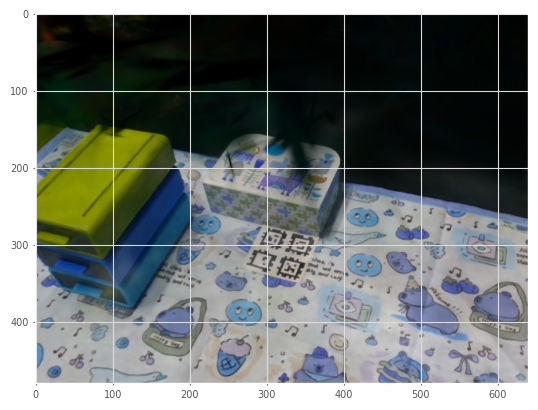

In [61]:
from matplotlib import pyplot as plt
# show image-image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
results = detector.detect(gray, estimate_tag_pose=True, camera_params=[fx, fy, cx, cy], tag_size=0.031)
print(results)